In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [28]:
rho= 1
mu= 1
nu=mu/rho
D= 1
L= 2
u_in=1
c_p=1000
l=0.02
t_in=300
t_BC=400

In [77]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((2,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 4)
])

NN.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,340 (9.14 KB)

 Trainable params: 2,340 (9.14 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)


In [79]:
def pde_loss(x, y, net, nu, rho, c_p, l):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)  
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32) 


    # Compute derivatives
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)

        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)

            u = net(tf.concat([x, y], axis=1))[:,0]
        u_x, u_y = g.gradient(u, [x, y])
    u_xx = g.gradient(u_x, x)
    u_yy = g.gradient(u_y, y)

    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)

        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)

            v = net(tf.concat([x, y], axis=1))[:,1]
        v_x, v_y = g.gradient(v, [x, y])
    v_xx = g.gradient(v_x, x)
    v_yy = g.gradient(v_y, y)
    
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)

        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)

            t = net(tf.concat([x, y], axis=1))[:,3]
        t_x, t_y = g.gradient(t, [x, y])
    t_xx = g.gradient(t_x, x)
    t_yy = g.gradient(t_y, y)
   
    with tf.GradientTape() as g:
        g.watch(x)
        g.watch(y)
      
        p = net(tf.concat([x, y], axis=1))[:,2]
        p_x, p_y = g.gradient(p, [x, y])
   

    # Compute PDE terms
    pde_u = u * u_x + v * u_y  + 1/rho * p_x - nu * (u_xx + u_yy )
    pde_v = u * v_x + v * v_y  + 1/rho * p_y - nu * (v_xx + v_yy )
    pde_t = rho*c_p*(u*t_x+v*t_y) - l*(t_xx+t_yy)
    pde_0 = u_x+ v_y
    

    # Compute square loss

    total_loss = tf.reduce_mean(tf.square(pde_u))+tf.reduce_mean(tf.square(pde_v))+tf.reduce_mean(tf.square(pde_0))+tf.reduce_mean(tf.square(pde_t))/138000000000

    return total_loss
def BC_loss(x, y, net, t_BC):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)  
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32) 

    # Compute boundary conditions
    # At the cylinder body
    bc_u =  net(tf.concat([x, y], axis=1))[:,0]
    bc_v =  net(tf.concat([x, y], axis=1))[:,1]
    bc_t =  net(tf.concat([x, y], axis=1))[:,3] - t_BC


    total_loss = tf.reduce_mean(tf.square(bc_u))+tf.reduce_mean(tf.square(bc_v))+tf.reduce_mean(tf.square(bc_t))/256500

    return total_loss


def IN_loss(x, y, net, u_in, t_in):

    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)  
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32) 

    # At the inlet
    bc_inlet_u = net(tf.concat([x, y], axis=1))[:,0] -u_in
    bc_inlet_v = net(tf.concat([x, y], axis=1))[:,1]
    bc_inlet_t = net(tf.concat([x, y], axis=1))[:,3] -t_in
    

    total_loss = tf.reduce_mean(tf.square(bc_inlet_u)) +tf.reduce_mean(tf.square(bc_inlet_v)) + tf.reduce_mean(tf.square(bc_inlet_t))/246200
    return total_loss
def OUT_loss(x, y, net):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)  
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32) 

    # At the outlet
    bc_outlet_p = net(tf.concat([x, y], axis=1))[:,2]
    square_loss= tf.square(bc_outlet_p)
    total_loss = tf.reduce_mean(square_loss)
    return total_loss

In [80]:
def generate_points_pde(L, D, N_pde):
    points = []
    while len(points) < N_pde:
        x = random.uniform(-L/2, L/2)
        y = random.uniform(-D/2, D/2)
        points.append((x, y))
    return np.array(points)
def generate_points_inlet(L, D, N_in):
    points = []
    while len(points) < N_in:
        x = random.uniform(-L/2, -L/2+L/1000)
        y = random.uniform(-D/2, D/2)
        points.append((x, y))
    return np.array(points)
def generate_points_outlet(L, D, N_out):
    points = []
    while len(points) < N_out:
        x = random.uniform(L/2-L/1000, L/2)
        y = random.uniform(-D/2, D/2)
        points.append((x, y))
    return np.array(points)
def generate_points_BC(L, D, N_BC):
    points = []
    while len(points) < N_BC:
        if len(points) % 2 == 0:  
            y = random.uniform(D/2 - D/1000, D/2)
        else:  
            y = random.uniform(-D/2, -D/2 + D/1000)
        x = random.uniform(-L/2, L/2)
        points.append((x, y))
    return np.array(points)

In [81]:
N_pde = 250
train_pde = generate_points_pde(L, D, N_pde)
train_x_pde=train_pde[:,0]
train_y_pde=train_pde[:,1]
N_BC = 250
train_BC = generate_points_BC(L, D, N_BC)
train_x_BC=train_BC[:,0]
train_y_BC=train_BC[:,1]
N_in = 250
train_in = generate_points_inlet(L, D, N_in)
train_x_in=train_in[:,0]
train_y_in=train_in[:,1]
N_out = 250
train_out = generate_points_outlet(L, D, N_out)
train_x_out=train_out[:,0]
train_y_out=train_out[:,1]



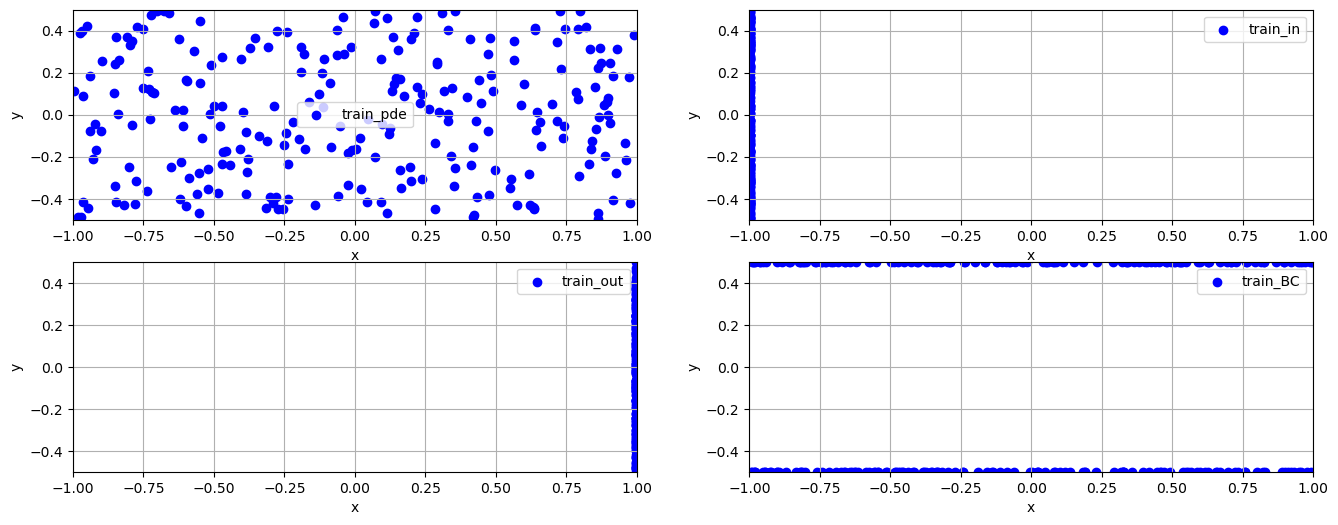

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))


axs[0,0].scatter(train_x_pde, train_y_pde, color='b', marker='o', label='train_pde')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0,0].set_xlim([-L/2, L/2])  
axs[0,0].set_ylim([-D/2, D/2]) 
axs[0,0].grid(True)
axs[0,0].legend()


axs[0,1].scatter(train_x_in, train_y_in, color='b', marker='o', label='train_in')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('y')
axs[0,1].set_xlim([-L/2, L/2])  
axs[0,1].set_ylim([-D/2, D/2]) 
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].scatter(train_x_out, train_y_out, color='b', marker='o', label='train_out')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1,0].set_xlim([-L/2, L/2])  
axs[1,0].set_ylim([-D/2, D/2]) 
axs[1,0].grid(True)
axs[1,0].legend()


axs[1,1].scatter(train_x_BC, train_y_BC, color='b', marker='o', label='train_BC')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('y')
axs[1,1].set_xlim([-L/2, L/2])  
axs[1,1].set_ylim([-D/2, D/2]) 
axs[1,1].grid(True)
axs[1,1].legend()


plt.show()

In [83]:
train_loss_record = []

for itr in range(15000):
    with tf.GradientTape() as tape:
        
        train_loss_BC= BC_loss (train_x_BC, train_y_BC, NN, t_BC)
        train_loss_IN= IN_loss (train_x_in, train_y_in, NN, u_in, t_in)
        
        train_loss_OUT= OUT_loss (train_x_out, train_y_out, NN)
        train_loss_pde = pde_loss(train_x_pde, train_y_pde, NN, nu, rho, c_p, l)
        total_loss =  train_loss_BC + train_loss_IN + train_loss_OUT +train_loss_pde
        
        train_loss_record.append(total_loss)
                
        grad_w = tape.gradient(total_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))
    
    if itr % 1000 == 999:
        print(total_loss.numpy())
        
#plt.figure(figsize = (10,8))
#plt.plot(train_loss_record)
#plt.show()

0.95478094
0.7500156
0.61184615
0.50008893
0.40387625
0.32626453
0.261947
0.21132174
0.17297183
0.14273457
0.12341195
0.11310968
0.10495639
0.10069856
0.098097816


15625/15625 ━━━━━━━━━━━━━━━━━━━━ 13s 811us/step


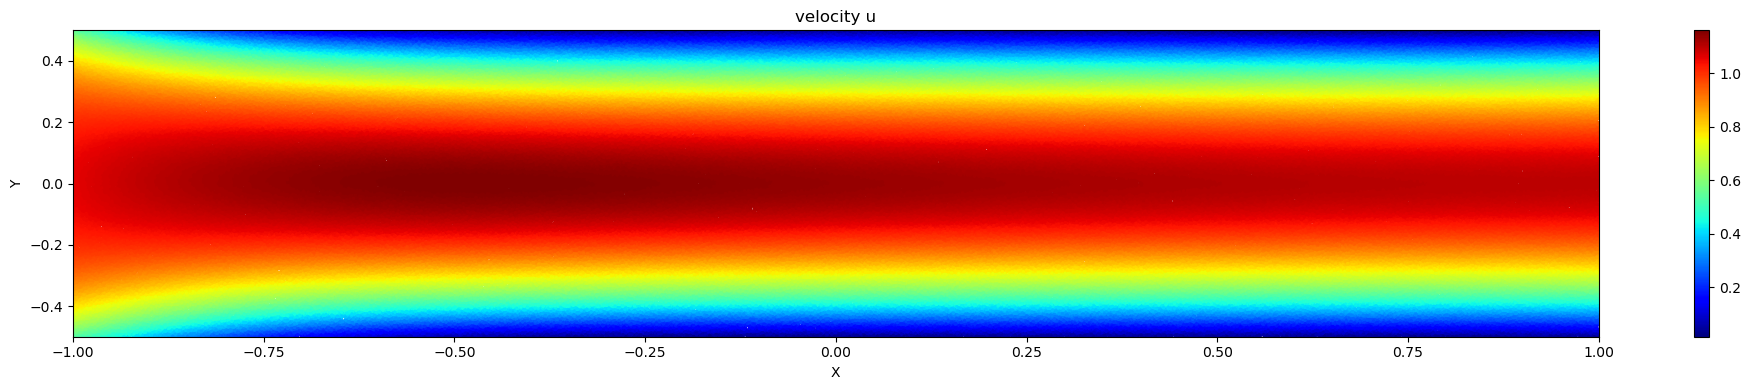

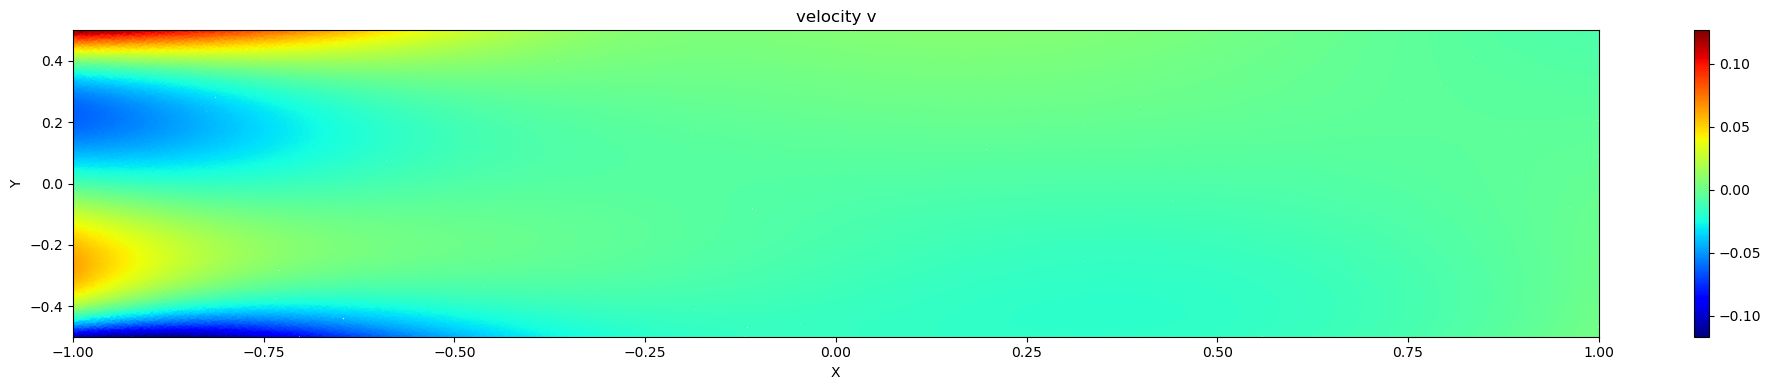

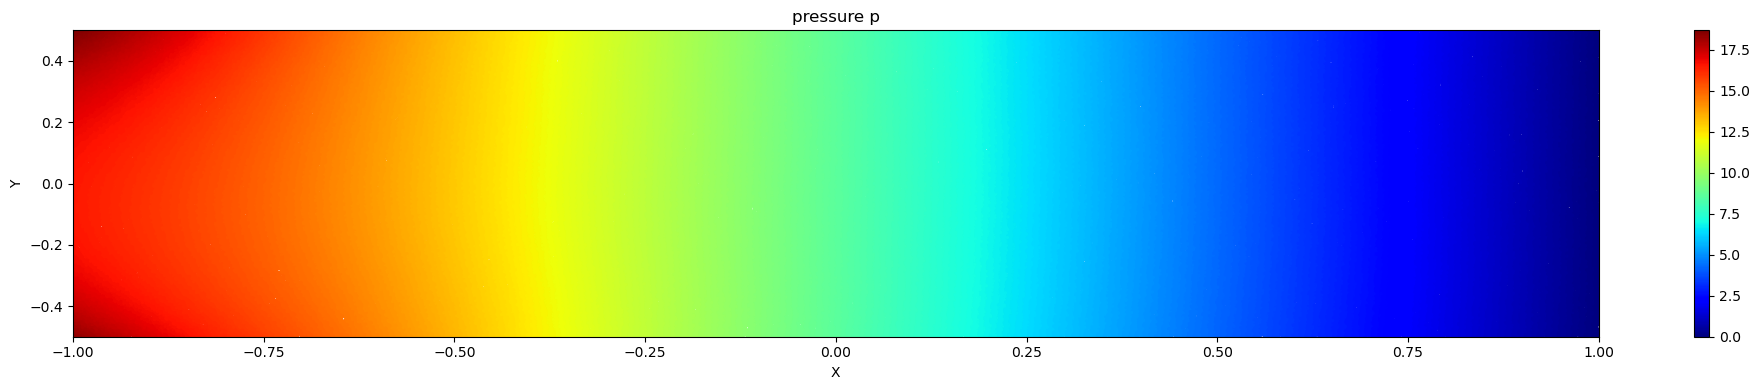

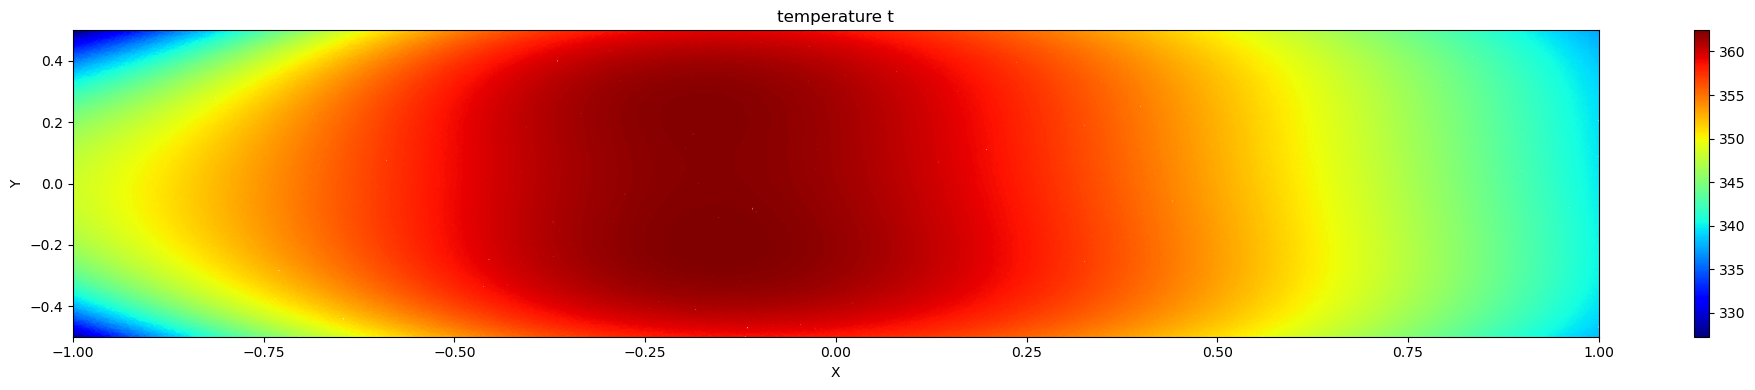

In [84]:
samples = np.random.rand(500000, 2)
samples[:, 0] = (samples[:, 0] - 0.5) * L    
samples[:, 1] = (samples[:, 1] - 0.5) * D  

result = NN.predict(samples)


titles = ['velocity u', 'velocity v', 'pressure p', 'temperature t']

for idx, title in enumerate(titles):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],  # Assuming z coordinate is the third dimension
                c=result[:, idx],
                cmap='jet',
                s=2)
    plt.colorbar()
    plt.title(title) 
    plt.xlabel('X') 
    plt.ylabel('Y')  
    #plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))  
    plt.ylim((-D/2, D/2))  
    plt.tight_layout()
    plt.savefig(f'plot_{idx+1}_{title}.png')  
    plt.show()

In [18]:
samples = np.random.rand(5000, 2)
samples[:, 0] = (samples[:, 0] - 0.5) * L    
samples[:, 1] = (samples[:, 1] - 0.5) * D  


x=samples[:, 0]
y=samples[:, 1]

In [23]:

def pde(x, y, net, nu, rho, c_p, l):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)  
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32) 


    # Compute derivatives
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)

        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)

            u = net(tf.concat([x, y], axis=1))[:,0]
        u_x, u_y = g.gradient(u, [x, y])
    u_xx = g.gradient(u_x, x)
    u_yy = g.gradient(u_y, y)

    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)

        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)

            v = net(tf.concat([x, y], axis=1))[:,1]
        v_x, v_y = g.gradient(v, [x, y])
    v_xx = g.gradient(v_x, x)
    v_yy = g.gradient(v_y, y)
    
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)

        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)

            t = net(tf.concat([x, y], axis=1))[:,3]
        t_x, t_y = g.gradient(t, [x, y])
    t_xx = g.gradient(t_x, x)
    t_yy = g.gradient(t_y, y)
   
    with tf.GradientTape() as g:
        g.watch(x)
        g.watch(y)
      
        p = net(tf.concat([x, y], axis=1))[:,2]
        p_x, p_y = g.gradient(p, [x, y])
   

    # Compute PDE terms
    pde_u = u * u_x + v * u_y  + 1/rho * p_x - nu * (u_xx + u_yy )
    pde_v = u * v_x + v * v_y  + 1/rho * p_y - nu * (v_xx + v_yy )
    pde_t = rho*c_p*(u*t_x+v*t_y) - l*(t_xx+t_yy)
    pde_0 = u_x+ v_y
    

    # Compute square loss
    square_loss = tf.square(pde_u) + tf.square(pde_v)  + tf.square(pde_0) +tf.square(pde_t)
    total_loss = tf.reduce_mean(square_loss)

    return tf.reduce_mean(tf.square(pde_u)), tf.reduce_mean(tf.square(pde_v)), tf.reduce_mean(tf.square(pde_0)), tf.reduce_mean(tf.square(pde_t))
pde(x, y, NN, nu, rho, 1000, 0.02)

(<tf.Tensor: shape=(), dtype=float32, numpy=5.060883>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0005562813>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.004343439>,
 <tf.Tensor: shape=(), dtype=float32, numpy=13711.295>)

In [24]:
def BC(x, y, net, t_BC):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)  
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32) 

    # Compute boundary conditions
    # At the cylinder body
    bc_u =  net(tf.concat([x, y], axis=1))[:,0]
    bc_v =  net(tf.concat([x, y], axis=1))[:,1]
    bc_t =  net(tf.concat([x, y], axis=1))[:,3] - t_BC

    square_loss= tf.square(bc_u) + tf.square(bc_v) + tf.square(bc_t)
    total_loss = tf.reduce_mean(square_loss)

    return tf.reduce_mean(tf.square(bc_u)), tf.reduce_mean(tf.square(bc_v)), tf.reduce_mean(tf.square(bc_t))
BC(x, y, NN, 400)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.62838465>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.4451526e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2594.6035>)

In [26]:
def IN(x, y, net, u_in, t_in):

    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)  
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32) 

    # At the inlet
    bc_inlet_u = net(tf.concat([x, y], axis=1))[:,0] -u_in
    bc_inlet_v = net(tf.concat([x, y], axis=1))[:,1]
    bc_inlet_t = net(tf.concat([x, y], axis=1))[:,3] -t_in
    
    square_loss= tf.square(bc_inlet_u) + tf.square(bc_inlet_v) + tf.square(bc_inlet_t)
    total_loss = tf.reduce_mean(square_loss)
    return tf.reduce_mean(tf.square(bc_inlet_u)), tf.reduce_mean(tf.square(bc_inlet_v)), tf.reduce_mean(tf.square(bc_inlet_t))
IN(x, y, NN, 1, 300)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.057338756>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.4451526e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2407.256>)

In [27]:
def OUT_loss(x, y, net):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)  
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32) 

    # At the outlet
    bc_outlet_p = net(tf.concat([x, y], axis=1))[:,2]
    square_loss= tf.square(bc_outlet_p)
    total_loss = tf.reduce_mean(square_loss)
    return total_loss
OUT_loss(x, y, NN)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00011510608>